In [1]:
%%time
import warnings
#warnings.filterwarnings("ignore")

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile

import sys, os, tempfile, boto3, glob, netCDF4, pyart, scipy
import numpy.ma as ma
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import Image, display
from botocore.handlers import disable_signing
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime, timedelta
from metpy.units import units
from metpy.plots import SkewT
import metpy.calc as metcalc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/jhemedinger/anaconda3/envs/vad/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jhemedinger/anaconda3/envs/vad/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


CPU times: user 1.05 s, sys: 60 ms, total: 1.11 s
Wall time: 1.13 s


In [20]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

import numpy as np

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile



def velocity_azimuth_display(radar, vel_field=None, z_want=None,
                             gatefilter=None):
    """
    Velocity azimuth display.
    
    Creates a VAD object containing U Wind V Wind and height, that
    can then be used to plot and produces the velocity azimuth
    display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """
    speeds = []
    angles = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)

    if vel_field is None:
        vel_field = get_field_name('velocity')

    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded,
            radar.fields[vel_field]['data'])
    else:
        velocities = radar.fields[vel_field]['data']

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if not (index_end - index_start) % 2 == 0:
            index_end = index_end - 1

        used_velocities = velocities[index_start:index_end]
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        speed, angle = _vad_calculation(
            used_velocities, azimuth, elevation)

        print('max height', z_gate_data[index_start, :].max(),
              'meters')
        speeds.append(speed)
        angles.append(angle)
        heights.append(z_gate_data[index_start, :])

    speed_array = np.concatenate(speeds)
    angle_array = np.concatenate(angles)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_mean, v_mean)
    return vad


def _vad_calculation(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number. All in degrees, m outdic contains
    speed and angle. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) == False, 0)

    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return speed, angle


def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(direction) * ((speed))), (np.cos(direction) * ((speed)))

In [21]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def get_radar_scan(station, desired_datetime):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    desired_datetime = datetime string of desired date and time for a radar key
              Example: datetime(2018,8,20,0,0,0) 
    '''
    
    #creating a bucket and a client to be able to pull data from AWS and setting 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting target string to get the key closest to desired_datetime
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+station)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]    
    
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix= target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], 
                                                         '%Y%m%d_%H%M%S'))
        except ValueError:
            pass 
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    keys = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    print(keys)
    return aws_radar, keys

In [88]:
aws_radar, keys = get_radar_scan('KDDC', datetime(2018,8,28,0,0,0))

localfile = tempfile.NamedTemporaryFile()
aws_radar.download_file(keys, localfile.name)
radar = pyart.io.read(localfile.name)

2018/08/28/KDDC/KDDC20180828_000007_V06


In [89]:
dataset = WyomingUpperAir.request_data(datetime(2018,8,28,0), 'DDC')

In [90]:
p = dataset['pressure'].values * units(dataset.units['pressure'])
ip100 = np.where(p.magnitude==100)[0][0]+1
h = dataset['height'].values * units(dataset.units['height'])
T = dataset['temperature'].values * units(dataset.units['temperature'])
Td = dataset['dewpoint'].values * units(dataset.units['dewpoint'])
u = dataset['u_wind'].values * units(dataset.units['u_wind'])
v = dataset['v_wind'].values * units(dataset.units['v_wind'])
s = dataset['speed'].values * units(dataset.units['speed'])
d = dataset['direction'].values * units(dataset.units['direction'])

h = h[:ip100]
p = p[:ip100]
T = T[:ip100]
Td = Td[:ip100]
u = ((u[:ip100]) * 0.514444)
v = ((v[:ip100]) * 0.514444)
s = ((s[:ip100]) * 0.514444)
d = d[:ip100]

hprofile = pyart.core.HorizontalWindProfile.from_u_and_v(h, u, v)
profile = pyart.core.HorizontalWindProfile(h, s, d)

In [91]:
gatefilter = pyart.correct.GateFilter(radar)
#gatefilter.exclude_below('reflectivity', 5)
gatefilter.exclude_invalid('velocity')

In [92]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field='velocity', keep_original=False, 
    gatefilter=gatefilter, centered=True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

sim_vel = pyart.util.simulated_vel_from_profile(radar, hprofile)
radar.add_field('sim_velocity', sim_vel, replace_existing=True)

In [93]:
print(radar.fields.keys())
#print(np.array(radar.fields['cross_correlation_ratio']['data']))

dict_keys(['velocity', 'spectrum_width', 'differential_phase', 'cross_correlation_ratio', 'differential_reflectivity', 'reflectivity', 'corrected_velocity', 'sim_velocity'])


In [94]:
print(np.shape(radar.fields['corrected_velocity']['data']))
print(np.shape(radar.fields['velocity']['data']))
print(np.shape(radar.fields['sim_velocity']['data']))

(6480, 1832)
(6480, 1832)
(6480, 1832)


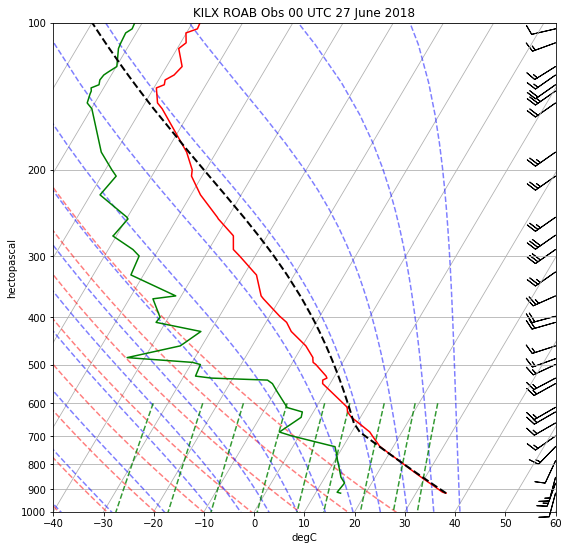

In [95]:
fig = plt.figure(figsize=(9,9))
skew = SkewT(fig)
skew.plot(p,T,'r')
skew.plot(p,Td,'g')
skew.plot_barbs(p[:-1:2], u[:-1:2], v[:-1:2])
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000,100)
skew.ax.set_xlim(-40,60)
prof = metcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, '--k', linewidth=2)
plt.title('KILX ROAB Obs 00 UTC 27 June 2018', loc='center')
#plt.savefig('/home/jhemedinger/suli_projects/chicago-nowcast/images/ilx_sounding_00UTC.png', dpi=300)
plt.show()

In [96]:
print(h.shape)
print(np.min(h), np.max(h))

(60,)
790 meter 16640 meter


In [97]:
z_want = np.linspace(790,16640,60)

In [98]:
vad = velocity_azimuth_display(radar, 'velocity', z_want=z_want)
print('----------------------')
vad_cor = velocity_azimuth_display(radar, 'corrected_velocity', z_want=z_want)
print('----------------------')
vad_sim = velocity_azimuth_display(radar, 'sim_velocity', z_want=z_want)

max height 15784.0 meters
max height 16312.0 meters
max height 19457.0 meters
max height 19480.0 meters
max height 22953.0 meters
max height 22997.0 meters
max height 27040.0 meters
max height 30707.0 meters
max height 36300.0 meters
max height 43462.0 meters
max height 52117.0 meters
max height 62555.0 meters
----------------------
max height 15784.0 meters
max height 16312.0 meters
max height 19457.0 meters
max height 19480.0 meters
max height 22953.0 meters
max height 22997.0 meters
max height 27040.0 meters
max height 30707.0 meters
max height 36300.0 meters
max height 43462.0 meters
max height 52117.0 meters
max height 62555.0 meters
----------------------
max height 15784.0 meters
max height 16312.0 meters
max height 19457.0 meters
max height 19480.0 meters
max height 22953.0 meters
max height 22997.0 meters
max height 27040.0 meters
max height 30707.0 meters
max height 36300.0 meters
max height 43462.0 meters
max height 52117.0 meters
max height 62555.0 meters


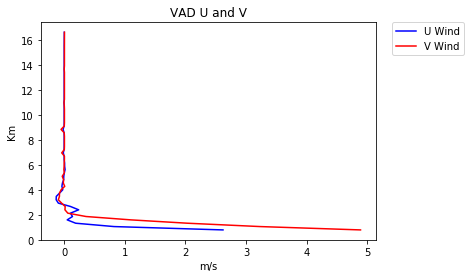

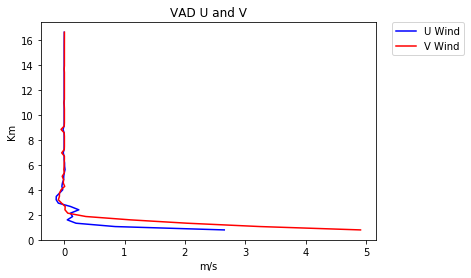

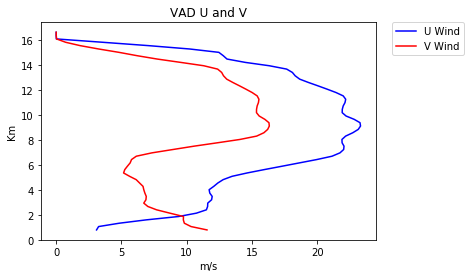

In [99]:
fig = plt.figure()
plt.plot(vad.u_wind, vad.height/1000, 'b-', label='U Wind')
plt.plot(vad.v_wind, vad.height/1000, 'r-', label='V Wind')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD U and V')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig = plt.figure()
plt.plot(vad_cor.u_wind, vad_cor.height/1000, 'b-', label='U Wind')
plt.plot(vad_cor.v_wind, vad_cor.height/1000, 'r-', label='V Wind')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD U and V')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig = plt.figure()
plt.plot(vad_sim.u_wind, vad_sim.height/1000, 'b-', label='U Wind')
plt.plot(vad_sim.v_wind, vad_sim.height/1000, 'r-', label='V Wind')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD U and V')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

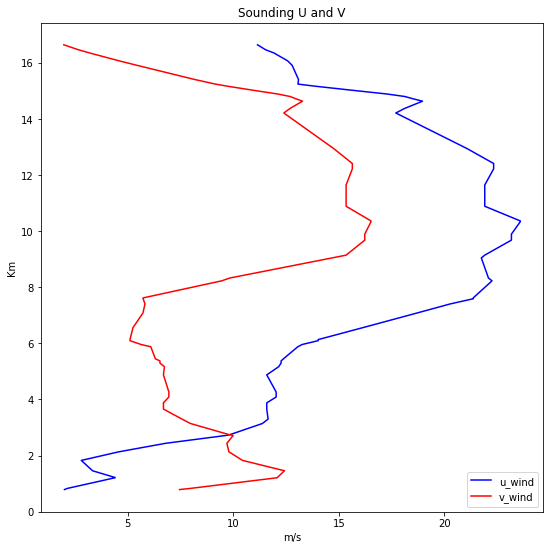

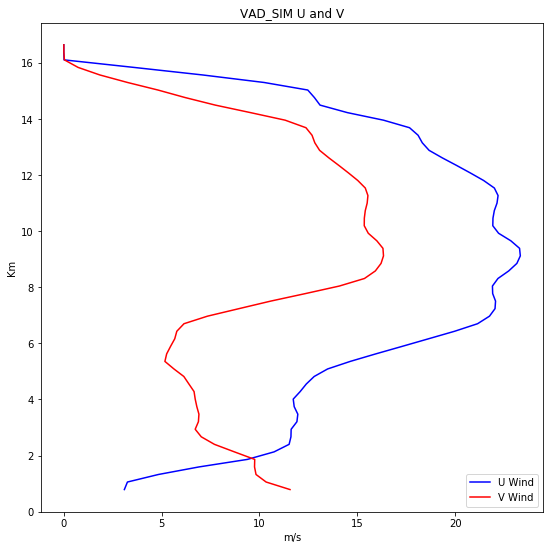

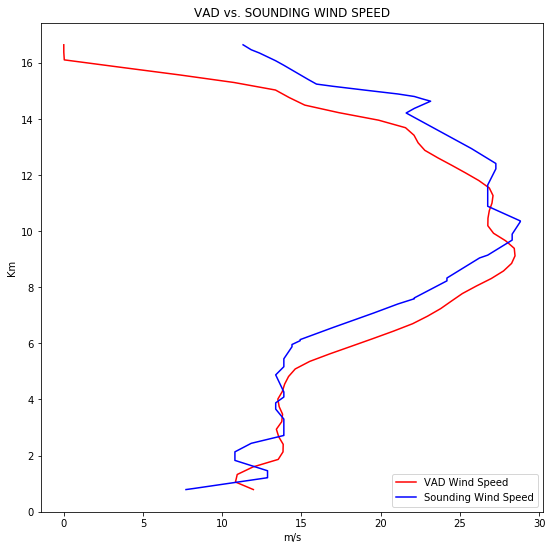

In [100]:
fig = plt.figure(figsize=(9,9))
plt.plot(u, h/1000, '-b', label='u_wind')
plt.plot(v, h/1000, '-r', label='v_wind')
plt.legend(loc=4)
#plt.xlim(-25,30)
#plt.ylim(0,37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('Sounding U and V')
#plt.savefig('sounding_uv', dpi=300)
plt.show()

fig = plt.figure(figsize=(9,9))
plt.plot(vad_sim.u_wind, vad_sim.height/1000, 'b-', label='U Wind')
plt.plot(vad_sim.v_wind, vad_sim.height/1000, 'r-', label='V Wind')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD_SIM U and V')
plt.legend(loc=4)
#plt.savefig('vad_sim_uv', dpi=300)
plt.show()


fig = plt.figure(figsize=(9,9))
plt.plot(vad_sim.speed, vad_sim.height/1000, 'r-', label='VAD Wind Speed')
plt.plot(s, h/1000, '-b', label='Sounding Wind Speed')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD vs. SOUNDING WIND SPEED')
plt.legend(loc=4)
#plt.grid()
#plt.savefig('vad_sounding_wind', dpi=300)
plt.show()

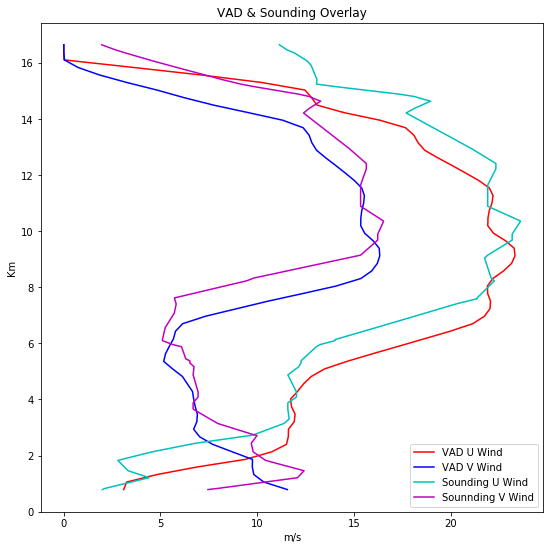

In [101]:
fig = plt.figure(figsize=(9,9))
plt.plot(vad_sim.u_wind, vad_sim.height/1000, 'r-', label='VAD U Wind')
plt.plot(vad_sim.v_wind, vad_sim.height/1000, '-b', label='VAD V Wind')
plt.plot(u, h/1000, '-c', label='Sounding U Wind')
plt.plot(v, h/1000, '-m', label='Sounnding V Wind')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD & Sounding Overlay')
plt.legend(loc=4)
#plt.grid()
#plt.savefig('michelson_vad.png', dpi=300)
plt.show()

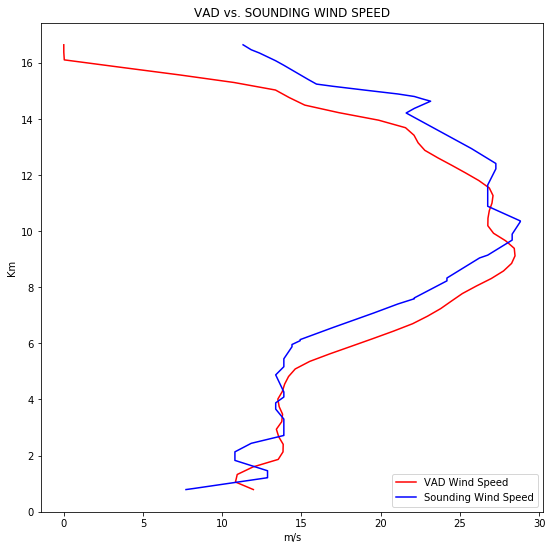

In [102]:
fig = plt.figure(figsize=(9,9))
plt.plot(vad_sim.speed, vad_sim.height/1000, 'r-', label='VAD Wind Speed')
plt.plot(s, h/1000, '-b', label='Sounding Wind Speed')
#plt.xlim(-25, 30)
#plt.ylim(0, 37)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD vs. SOUNDING WIND SPEED')
plt.legend(loc=4)
#plt.grid()
#plt.savefig('vad_sounding_wind', dpi=300)
plt.show()

In [87]:
print(np.array(d))
print(np.array(vad_sim.direction))

[185. 187. 210. 214. 219. 220. 210. 227. 230. 230. 231. 235. 235. 235.
 245. 240. 237. 234. 230. 230. 228. 225. 225. 235. 235. 228. 225. 224.
 220. 210. 210. 212. 214. 216. 220. 220. 215. 215. 221. 227. 235. 229.
 225. 235. 233. 230. 230. 228. 220. 224. 230. 234. 235. 235. 242. 245.
 245. 239. 236. 235. 250. 255. 268. 270. 258. 247. 230. 230. 230. 230.]
[215.87933035 213.51486995 225.60797881 230.08916347 231.67391712
 234.59491122 235.18852272 237.23788818 241.45894023 243.93054452
 242.6055087  240.45677045 237.29180733 233.36867681 229.82892995
 227.43901199 228.15044925 231.70449206 232.11977835 226.29839348
 217.46776913 212.08686881 212.79682974 214.56746572 216.5418887
 218.00544645 218.4034867  218.78199535 221.82111106 227.6432352
 231.22506319 230.24229205 228.55561307 228.8301157  231.16767234
 232.55917339 231.7196417  230.22169785 228.49940347 226.85707659
 224.42332126 222.16247396 223.20962445 224.71970843 226.38769807
 228.23226198 230.34781954 232.23329348 234.52042948